# VGG16

## Imports of required libraries used in this notebook

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

## GPU Memory Allocation

This code sets up the allocation of GPU memory using TensorFlow. The `os.environ` line specifies which GPU devices to use, and `tf.config.list_physical_devices()` lists the available physical devices. The memory growth option is set to `True` for the first GPU device in `physical_devices` using `tf.config.experimental.set_memory_growth()`. Finally, a TensorFlow session is created with logging for device placement.

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



## Plotting Model History

This code defines a function to plot the history of a deep learning model. The function takes in a `hist` object, which is the output of the `fit()` method in Keras and represents the history of the model during training. The function extracts the accuracy, loss, validation accuracy, and validation loss from `hist.history`. It also finds the epoch with the lowest validation loss and highest validation accuracy, and annotates the corresponding points on the plot. The function then plots the accuracy and loss against the number of epochs, and displays the plot using Matplotlib.

In [3]:
def hist_plot(hist):
    start_epoch = 0
    t_accuracy = hist.history['accuracy']
    t_loss = hist.history['loss']
    vacc = hist.history['val_accuracy']
    v_loss = hist.history['val_loss']
    Epoch_count = len(t_accuracy) + start_epoch
    Epochs = []
    for l in range(start_epoch, Epoch_count):
        Epochs.append(l + 1)
    index_loss = np.argmin(v_loss)  #  this is the epoch with the lowest validation loss
    val_lowest = v_loss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    index_acc = np.argmax(vacc)
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(Epochs, t_accuracy, 'r', label='Train')
    axes[0].plot(Epochs, vacc, 'g', label='Validation')
    axes[0].scatter(index_acc + 1 + start_epoch, acc_highest, s=200, c='yellow', label=vc_label)
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='upper left')

    axes[1].plot(Epochs, t_loss, 'r', label='Train')
    axes[1].plot(Epochs, v_loss, 'g', label='Validation')
    axes[1].scatter(index_loss + 1 + start_epoch, val_lowest, s=200, c='yellow', label=sc_label)
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## Evaluating Model Performance on Test Data

This code defines a function to evaluate the performance of a trained deep learning model on test data. The function takes in two arguments: `test`, which is the test data to be evaluated, and `model_use`, which is the trained model to be evaluated. 

The function uses the `evaluate()` method in Keras to calculate the test loss and accuracy. It then prints out the results in a formatted string. The function returns the `results` object.


In [4]:
def result_test(test, model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

## Creating a category dictionary and list

- `category_dict`: A dictionary that maps the class labels (represented by the 16 image categories) to their respective class names.
- `category_list`: A list containing the 16 image categories represented as class labels.

In [5]:
category_dict = {'n02121808': 'Domestic Cat', 'n02084071': ' Dog', 'n01503061': ' Bird', 'n02510455': ' Giant Panda', 'n01443537': ' Gold Fish', 'n02958343': ' Car', 'n02317335': ' Starfish', 'n07739125': ' Apple', 'n02391049': ' Zebra', 'n02691156': ' Airplane', 'n03991062': ' Flower Pot', 'n02274259': ' Butterfly', 'n02129165': ' Lion', 'n04131690': ' Salt or Pepper Shaker', 'n04004767': ' Printer', 'n06874185': ' Traffic Light'}

category_list = ['n01443537', 'n01503061', 'n02084071', 'n02121808', 'n02129165', 'n02274259', 'n02317335', 'n02391049', 'n02510455', 'n02691156', 'n02958343', 'n03991062', 'n04004767', 'n04131690', 'n06874185', 'n07739125']

## Define Model Parameters

The code defines the parameters that will be used for building the CNN model. These include the input shape, number of classes, batch size and number of epochs.

In [6]:
input_shape = (224, 224, 3)
num_classes = 16
batch_size = 32
epochs = 150


## Directory Paths

The above code defines directory paths for the training, validation, and testing dataset directories. The base directory is set to './image_dataset' and the training, validation, and testing directories are defined by joining 'train', 'val', and 'test' strings respectively to the base directory using os.path.join() function.

In [7]:
base_dir = './image_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


## Dataset Path and Image Count

The code sets the path to the dataset and initializes an empty list `dataset_images`. It then loops through three subdirectories (`/train/`, `/val/`, and `/test/`) in the dataset directory using `glob` to find all image files with `.jpeg` extension and adds them to the `dataset_images` list. Finally, it prints the total number of images in the dataset.

In [8]:
dataset_path = './image_dataset'
dataset_images = []
for i in ['/train/', '/val/', '/test/']:
    dataset_images.extend(list(glob.glob(dataset_path + i + '/**/*.jpeg')))
print('Number of images in dataset: ', len(dataset_images))

Number of images in dataset:  9171


## Dataframe Creation and Exploration

This code creates a Pandas dataframe containing the file path, label, and category information of the images in the dataset. The `labels` variable extracts the label information from the file path of each image, while the `categories` variable maps the label to its corresponding category name using the `category_dict` dictionary. The `file_path`, `labels`, and `categories` information are then combined into a single dataframe using the `pd.concat()` function.

The dataframe is then shuffled randomly using the `sample()` function and the `frac` parameter is set to `1` to shuffle the entire dataset. Finally, the first 15 rows of the dataframe are printed to check the dataframe structure and data.

In [9]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], dataset_images))
categories = list(map(lambda x: category_dict[x], labels))
file_path = pd.Series(dataset_images, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
category = pd.Series(categories, name='Category')
data = pd.concat([file_path, labels, category], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

# Printing the first 10 data from the dataframe
data.head(15)

,File_Path,Labels,Category
0,./image_dataset/train\n01503061\n01503061_1330...,n01503061,Bird
1,./image_dataset/test\n01443537\n01443537_10078...,n01443537,Gold Fish
2,./image_dataset/train\n04004767\n04004767_1142...,n04004767,Printer
3,./image_dataset/val\n02121808\n02121808_4168.JPEG,n02121808,Domestic Cat
4,./image_dataset/val\n02274259\n02274259_16846....,n02274259,Butterfly
5,./image_dataset/train\n02958343\n02958343_3387...,n02958343,Car
6,./image_dataset/test\n02317335\n02317335_28710...,n02317335,Starfish
7,./image_dataset/train\n04131690\n04131690_1238...,n04131690,Salt or Pepper Shaker
8,./image_dataset/train\n04004767\n04004767_5746...,n04004767,Printer
9,./image_dataset/val\n02317335\n02317335_26756....,n02317335,Starfish


## Displaying sample images from the dataset

This code displays sample images from the dataset using matplotlib. It plots a 4x4 grid of images with their corresponding categories as titles. The code first creates a subplot using `plt.subplots()` with 4 rows and 4 columns. It then loops through the axes in the grid and displays each image by reading the file path from the `data` dataframe and setting it as the image source. The title of each image is set as the corresponding category from the `data` dataframe. Finally, it uses `plt.tight_layout()` to adjust the spacing of the subplots and `plt.show()` to display the plot.

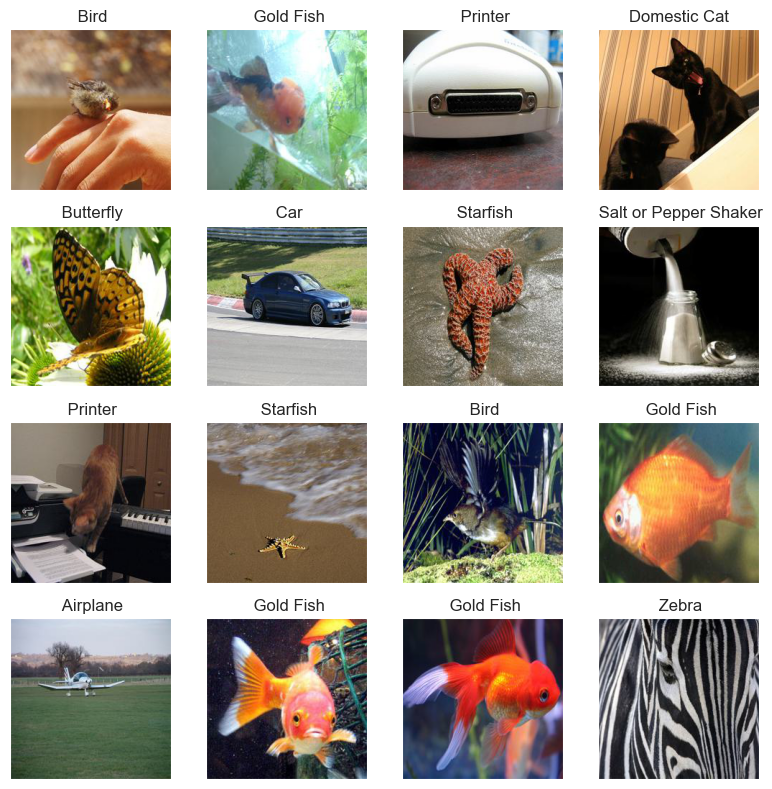

In [10]:
fig, axe = plt.subplots(nrows=4, ncols=4, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axe.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Category[i])
plt.tight_layout()
plt.show()

## Bar graph for count of images in each category

This code creates a bar graph using the seaborn library to show the count of images in each category of the dataset. The x-axis shows the categories and the y-axis shows the count of images. The graph is displayed with the x-axis labels rotated by 90 degrees to make them more readable. The 'palette' argument is used to set the color palette for the bars.

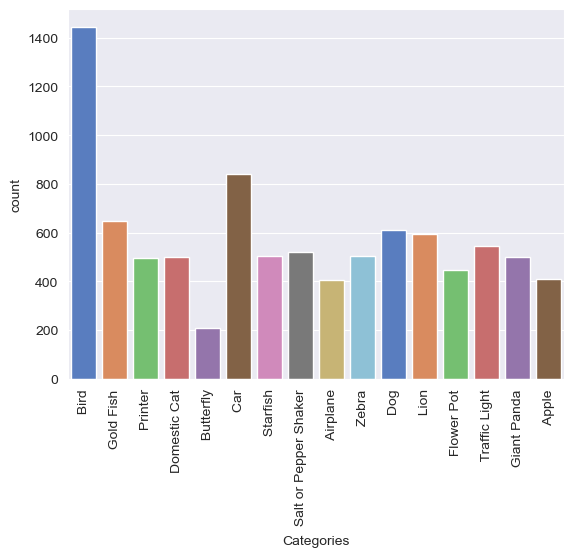

In [11]:
sns.countplot(x="Category", data=data, palette="muted")
plt.xlabel('Categories')
plt.xticks(rotation=90);

## Image Data Generation and Data Augmentation

This code uses the ImageDataGenerator class from the Keras API to generate new images from the existing dataset by applying various transformations like rotation, shift, shear, zoom, and flip. This is done separately for the training and validation datasets. The test dataset is not augmented, but only rescaled to the range of 0 to 1. The flow_from_directory() method is used to create batch generators for each dataset, which will be used for model training and evaluation.

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 6412 images belonging to 16 classes.
Found 1828 images belonging to 16 classes.
Found 931 images belonging to 16 classes.


## VGG16-based Model for Image Classification

This is a custom model based on the VGG16 architecture that has been fine-tuned for image classification on a specific dataset. The pre-trained VGG16 model is used as a base, with the top layers removed and new layers added for classification. The model includes two dense layers with dropout regularization, followed by a softmax output layer.

In [13]:
# Load the VGG16 model without the top layers
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
for layer in vgg_base.layers:
    layer.trainable = False

# Add new top layers for classification
x = vgg_base.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

## Compiling the model with Adam optimizer and categorical cross-entropy loss

This code snippet shows the compilation of the above model using the Adam optimizer with a learning rate of 0.0001 and categorical cross-entropy loss. The model architecture consists of a VGG16 base model with the top layers replaced for classification. The model is compiled with the specified optimizer, loss function, and accuracy metric for training.

In [14]:
optimizer = Adam(learning_rate=0.0001)

model = Model(inputs=vgg_base.input, outputs=predictions)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


## Training and Validation with Early Stopping and Model Checkpoint

This code block trains the `model` with the `train_generator` and `val_generator` for a specified number of `epochs`, while monitoring the validation loss for early stopping and saving the best model using model checkpoint. The `history` variable stores the training history for further analysis.

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=14, verbose=1, restore_best_weights=True),
             ModelCheckpoint('./models/VGG16.h5', monitor='val_loss', save_best_only=True)]
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=callbacks)

Epoch 1/150
201/201 [==============================] - 88s 412ms/step - loss: 2.4881 - accuracy: 0.2071 - val_loss: 2.0540 - val_accuracy: 0.3889
Epoch 2/150
201/201 [==============================] - 70s 349ms/step - loss: 2.0649 - accuracy: 0.3412 - val_loss: 1.7270 - val_accuracy: 0.5274
Epoch 3/150
201/201 [==============================] - 72s 358ms/step - loss: 1.8236 - accuracy: 0.4209 - val_loss: 1.4915 - val_accuracy: 0.5837
Epoch 4/150
201/201 [==============================] - 76s 376ms/step - loss: 1.6479 - accuracy: 0.4693 - val_loss: 1.3691 - val_accuracy: 0.6204
Epoch 5/150
201/201 [==============================] - 77s 381ms/step - loss: 1.5466 - accuracy: 0.5020 - val_loss: 1.2119 - val_accuracy: 0.6586
Epoch 6/150
201/201 [==============================] - 76s 379ms/step - loss: 1.4072 - accuracy: 0.5515 - val_loss: 1.1267 - val_accuracy: 0.6696
Epoch 7/150
201/201 [==============================] - 78s 386ms/step - loss: 1.3387 - accuracy: 0.5669 - val_loss: 1.0285 -

## Code to test the model on the test set

This code block evaluates the model on the test set using the `test_generator` and prints the test loss and accuracy.

In [16]:
test_result = result_test(test_generator, model)

    Test Loss: 0.45479
Test Accuracy: 85.61%


## Plotting the training and validation loss and accuracy

This code creates plots to visualize the training and validation loss and accuracy of the model during training. It takes in the `history` object returned by the `fit()` function and generates plots of training and validation accuracy and loss. The plots are stored in the `model_plots` object.

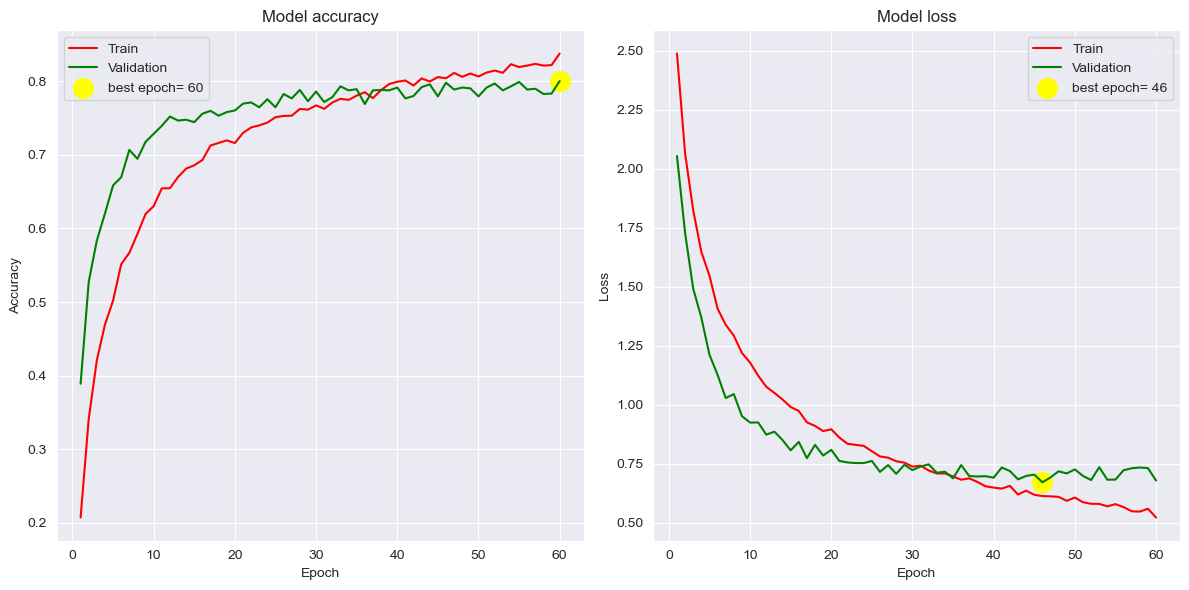

In [17]:
model_plots = hist_plot(history)

## Evaluate the Model Performance

This code evaluates the model's performance on the test set by generating the true labels and predicted labels. It uses the `classification_report` function from `sklearn.metrics` to generate a report of various classification metrics such as precision, recall, and f1-score for each class in the target names list.

In [18]:
# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

target_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

30/30 [==============================] - 7s 218ms/step
              precision    recall  f1-score   support

   n01443537       0.87      0.88      0.87        66
   n01503061       0.82      0.87      0.84       145
   n02084071       0.69      0.55      0.61        62
   n02121808       0.76      0.68      0.72        50
   n02129165       0.81      0.95      0.88        60
   n02274259       0.88      0.95      0.91        22
   n02317335       0.87      0.80      0.84        51
   n02391049       0.94      0.96      0.95        51
   n02510455       0.93      0.80      0.86        51
   n02691156       0.84      0.90      0.87        42
   n02958343       0.91      0.95      0.93        85
   n03991062       0.86      0.96      0.91        45
   n04004767       0.91      0.94      0.92        51
   n04131690       0.87      0.85      0.86        53
   n06874185       0.85      0.95      0.90        55
   n07739125       1.00      0.69      0.82        42

    accuracy             

## Confusion Matrix Plotting

This code generates a confusion matrix for the predictions made by the model on the test set. The true labels and predicted labels are obtained, and a heatmap of the confusion matrix is plotted using seaborn library. The x-axis and y-axis of the heatmap represent predicted and true labels respectively. The diagonal elements of the heatmap represent the number of samples that were correctly classified, and the off-diagonal elements represent the number of samples that were misclassified.

30/30 [==============================] - 6s 218ms/step


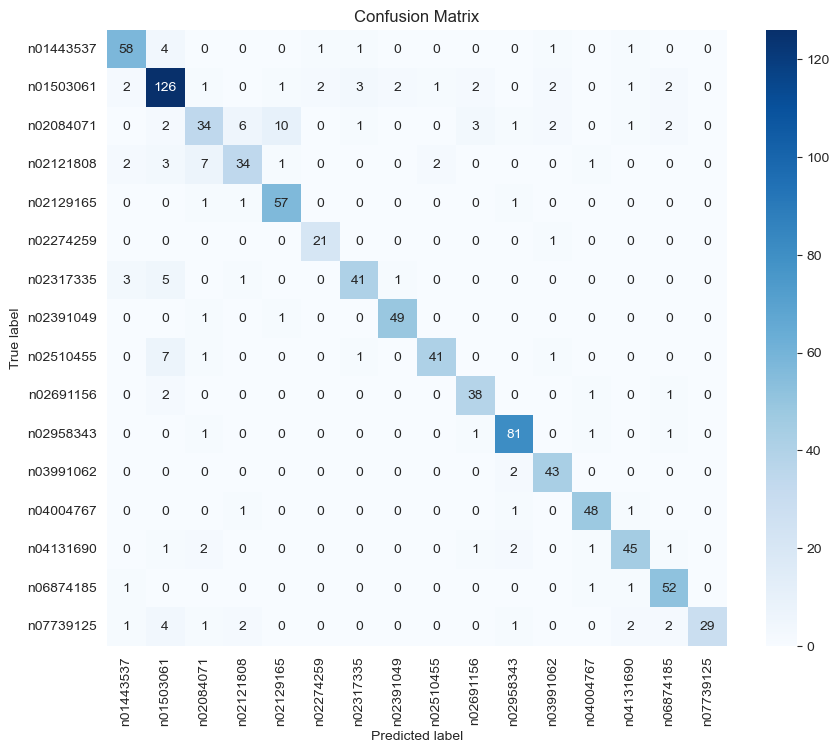

In [19]:
# Generate predictions for the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmapO
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Plotting ROC Curve for Multiclass Classification Model

This code generates the ROC (Receiver Operating Characteristic) curve for a multiclass classification model, using the test set. It computes the FPR (False Positive Rate) and TPR (True Positive Rate) for each class, and then plots the ROC curve for each class. The AUC (Area Under the Curve) value is also computed and displayed in the legend for each class. The code uses Matplotlib to create the plot and sets the plot parameters, including the x and y labels, title, and legend location.


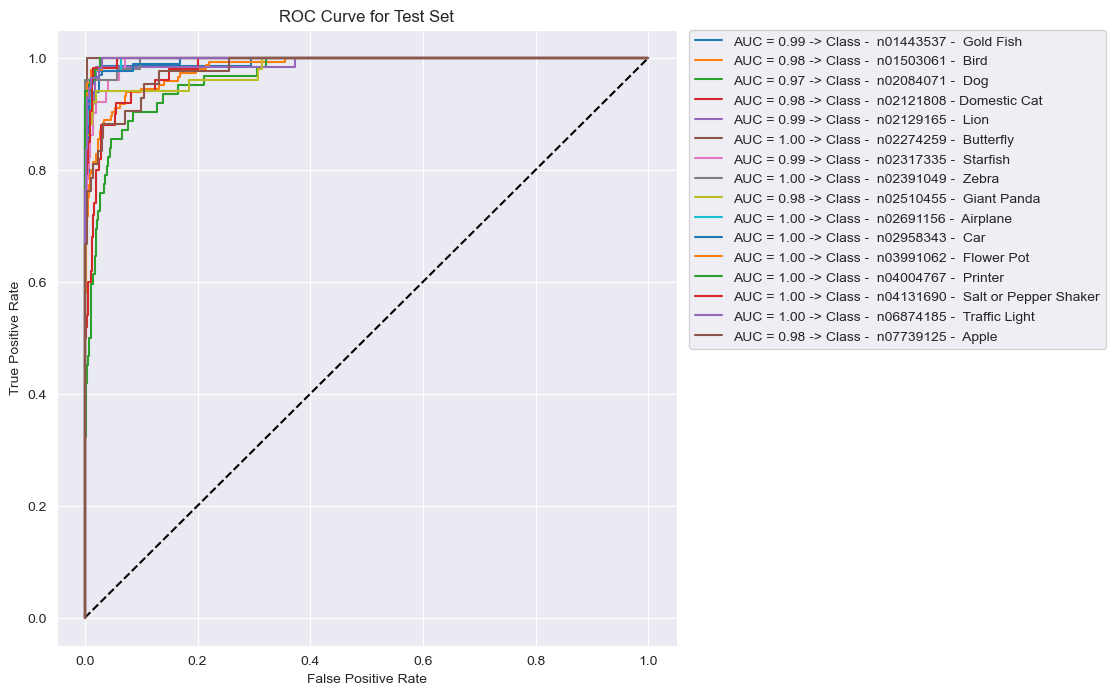

In [20]:
# Get true labels of test data
y_true = test_generator.classes

# Compute FPR and TPR for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='AUC = %.2f -> Class -  %s - %s' %
             (roc_auc[i], category_list[i], category_dict[category_list[i]]))

# Set plot parameters
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


## Plotting Precision-Recall Curve for Multiclass Classification Model

This code generates the Precision-Recall curve for a multiclass classification model, using the test set. It computes the class-wise precision and recall pairs and then plots the Precision-Recall curve for each class. The code also computes the average precision score and displays it in the title of the plot. The class names are obtained from the test set's class indices. The code uses Matplotlib to create the plot and sets the plot parameters, including the x and y labels, title, and legend location.

30/30 [==============================] - 6s 218ms/step


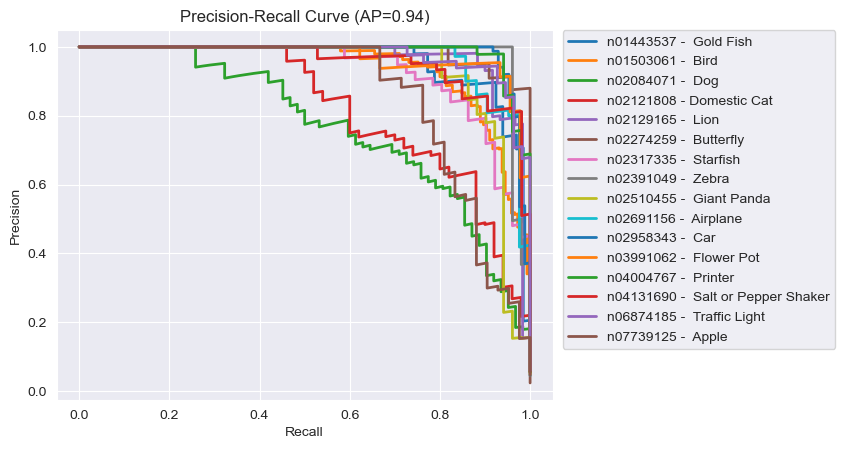

In [21]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Compute the average precision score
average_precision = average_precision_score(to_categorical(y_true), y_pred, average='weighted')

# Compute the precision-recall pairs for each class
precision = dict()
recall = dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(to_categorical(y_true)[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(class_names[i] + ' - ' + category_dict[class_names[i]]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Show the plot
plt.show()

## Model Summary

This code displays a summary of the neural network model's architecture. It shows the layers of the model, the number of parameters, and the output shape of each layer. This information can help in understanding the complexity of the model and identifying potential issues such as overfitting.

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     